In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=d784e605622d5d4c63b5c1212ccdcfbc87a8360ade242d5059033abf6c6f4a9a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [42]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 9.2 GB  | Proc size: 6.5 GB
GPU RAM Free: 11778MB | Used: 3301MB | Util  22% | Total 15079MB


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [34]:
SEED_VALUE = 1  # これはなんでも良い

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split

drive_dir ="/content/drive/My Drive/Colab Notebooks/BERT/"

# データの読込(段階1)
#df = pd.read_excel(drive_dir + 'train/台風豪雨福島.xlsx')
df = pd.read_excel(drive_dir + 'train/台風豪雨福島_4単語差し替え.xlsx')
train_df_unreplace, _ = train_test_split(df, test_size=0.2, shuffle=True, random_state=SEED_VALUE, stratify=df[['label','type']])
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=SEED_VALUE, stratify=df[['label','type']])
# ↑3クラス分類の場合

#df_replaced= df.replace({'label':{2:1}})  #1.5次(上半分)を1次or2次に混ぜる
#train_df, test_df = train_test_split(df_replaced, test_size=0.2, shuffle=True, random_state=SEED_VALUE, stratify=df[['label','type']])
# ↑1次,1.5次,|2次
#   525 525    1050  をtrain_test_split


# データの読込(段階2)
# df_reserve = pd.read_excel(drive_dir + 'train/台風豪雨福島_binary_reserve_pri.xlsx')
# df_reserve, _ = train_test_split(df_reserve, test_size=0.2, shuffle=True, random_state=SEED_VALUE, stratify=df[['label','type']])  #数合わせが必要なら実行
# df_classified = pd.read_excel(drive_dir + 'train/台風豪雨福島_single_classified.xlsx')
# test_df = df_classified[df_classified.pred ==  0]
# #test_df = test_df[test_df.label ==  0]           # 2値分類の対象外クラスの除外が必要なら実行

# train_df1 = train_df_unreplace[train_df_unreplace.label == 0]
# train_df2 = train_df_unreplace[train_df_unreplace.label == 2]
# train_df3 = df_reserve[df_reserve.label == 2]     #1.5次の下半分を補充
# #train_df4 = df_reserve[df_reserve.label == 0]    #1次の下半分が必要なら補充

# train_df = pd.concat([train_df1, train_df2,train_df3])
# train_df = train_df.sample(frac=1, random_state=123)

# try:
#   test_df['label'] = test_df['raw_label']
# except KeyError:
#   pass

# train_df = train_df.replace({'label':{2:1}})
# test_df = test_df.replace({'label':{2:1}})
#↑1次|1.5次
# 945   945   テストデータ105件ずつを除いた全て

#事例数の確認
print('【学習データ】')
print(train_df['label'].value_counts())
print('【評価データ】')
print(test_df['label'].value_counts())
print('【データ種類】')
print(train_df['type'].value_counts())

train_df.to_csv(drive_dir + 'train.tsv', sep='\t', index=False, header=None)
test_df.to_csv(drive_dir + 'test.tsv', sep='\t', index=False, header=None)

【学習データ】
1    840
2    840
0    840
Name: label, dtype: int64
【評価データ】
2    210
1    210
0    210
Name: label, dtype: int64
【データ種類】
f    840
t    840
g    840
Name: type, dtype: int64


In [6]:
# MeCabとtransformersを用意する
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
# 以下で報告があるようにmecab-python3のバージョンを0.996.5にしないとtokezerで落ちる
# https://stackoverflow.com/questions/62860717/huggingface-for-japanese-tokenizer
!pip install mecab-python3==0.996.5
!pip install unidic-lite # これないとMeCab実行時にエラーで落ちる
!pip install transformers==3.5.1
!pip install fugashi
!pip install ipadic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp

In [7]:
import torch
import torchtext
from transformers import BertModel, BertJapaneseTokenizer

# 日本語BERTの分かち書き用tokenizerを宣言
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# 試しに分かち書きしてみる。
# text = list(train_df['Text'])[0]
# wakati_ids = tokenizer.encode(text, return_tensors='pt')
# print(tokenizer.convert_ids_to_tokens(wakati_ids[0].tolist()))
# print(wakati_ids)
# print(wakati_ids.size())

131


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


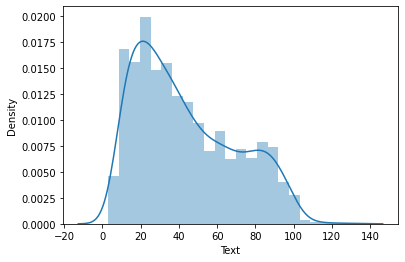

In [8]:
# 日本語BERTで扱える文章の長さは512だけど、学習データのツイートの長さは最大でもCLS, SEPトークン入れても131
import seaborn as sns
title_length = df['Text'].map(tokenizer.encode).map(len)
print(max(title_length))

sns.distplot(title_length)

In [44]:
# torchtextを使って、学習データとテストデータのイテレータを作成
def bert_tokenizer(text):
  return tokenizer.encode(text, return_tensors='pt')[0]

TEXT = torchtext.data.Field(sequential=True, tokenize=bert_tokenizer, use_vocab=False, lower=False,
                            include_lengths=True, batch_first=True, pad_token=0)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

train_data, test_data = torchtext.data.TabularDataset.splits(
    path=drive_dir, train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('label', LABEL)])

# BERTではミニバッチサイズは16か32を使うようですが、ツイートは文章の長さが短いので32でもcolab上で動きます。
BATCH_SIZE = 32
train_iter, test_iter = torchtext.data.Iterator.splits((train_data, test_data), batch_sizes=(BATCH_SIZE, BATCH_SIZE), repeat=False, sort=False)

In [10]:
from transformers import BertModel
model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

In [45]:
import os

import numpy as np
from torch import nn
import torch.nn.functional as F
from transformers import BertModel


os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [46]:
class BertClassifier(nn.Module):
  def __init__(self):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
    self.dense1 = torch.nn.Linear(768*4, 768*4)
    self.dense2 = torch.nn.Linear(768*4, 768*4)
    self.drop = torch.nn.Dropout(0.4)
    self.linear = nn.Linear(768, 3)
    # 重み初期化処理
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  # clsトークンのベクトルを取得する用の関数を用意
  def _get_cls_vec(self, vec):
    return vec[:,0,:].view(-1, 768)

  def forward(self, input_ids):
    # last_hidden_stateとattentionsを受け取る
    vec, _, attentions = self.bert(input_ids, output_attentions=True)
    # 全ての隠れ層の状態を取得する
    _, _, hidden_states = self.bert(input_ids, output_hidden_states=True)

    # 1:先頭トークンclsのベクトルだけ取得
    vec = vec[:,0,:]
    vec = vec.view(-1, 768)

    # 2:最終４層の隠れ層からそれぞれclsトークンのベクトルを取得する
    # vec1 = self._get_cls_vec(hidden_states[-1])
    # vec2 = self._get_cls_vec(hidden_states[-2])
    # vec3 = self._get_cls_vec(hidden_states[-3])
    # vec4 = self._get_cls_vec(hidden_states[-4])

    # 4つのclsトークンを結合して１つのベクトルにする。
    # vec = torch.cat([vec1, vec2, vec3, vec4], dim=1)
    # vec = self.dense1(vec)
    # vec = self.dense2(vec)
    
    # 全結合層でクラス分類用に次元を変換
    out = self.linear(vec)
    return F.log_softmax(out), attentions

classifier = BertClassifier()

In [47]:
import torch.optim as optim
learning_rate = 5e-5

# optimizer setting
param_optimizer = list(classifier.named_parameters())
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
optimizer_grouped_parameters = []
max_lrs = []
for param in param_optimizer:
  if any(n in param[0] for n in no_decay):
    weight_decay = 0.0
  else:
    weight_decay = 0.1
  if param[0].find("bert.encoder.layer") != -1:
    n_diff_last = 11 - int(param[0].split(".")[3])
    lr = learning_rate*0.9**n_diff_last
  elif "embeddings" in param[0]:
    lr = learning_rate*0.9**11
  else:
    lr = learning_rate
  max_lrs.append(lr)
  d = {"params": param[1], "weight_decay": weight_decay}
  optimizer_grouped_parameters.append(d)

optimizer = optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [48]:
n_epoch = 5
max_grad_norm = 1.0

# 学習時間を測ります。
import time

start = time.time()

# GPUの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# ネットワークをGPUへ送る
classifier.to(device)
classifier = classifier.train()

num_training_steps = len(train_iter)*n_epoch
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lrs, total_steps=num_training_steps)

classifier.zero_grad()
optimizer.zero_grad()

# エポック数
for epoch in range(n_epoch):
  lr = np.array([param_group["lr"] for param_group in optimizer.param_groups]).mean()
  all_loss = 0
  for idx, batch in enumerate(train_iter):
    batch_loss = 0
    classifier.zero_grad()
    input_ids = batch.Text[0].to(device)
    label_ids = batch.label.to(device)
    out, _ = classifier(input_ids)

    batch_loss = loss_function(out, label_ids)
    batch_loss.backward()
    torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_grad_norm) 
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    all_loss += batch_loss.item()
  print("epoch", epoch, "\t" , "loss", all_loss)

end = time.time()
print ("time : ", end - start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 	 loss 88.50120711326599
epoch 1 	 loss 64.34066408872604
epoch 2 	 loss 45.145352721214294
epoch 3 	 loss 28.228473842144012
epoch 4 	 loss 18.75167505443096
time :  335.3750190734863


In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


classifier.eval()

answer = []
prediction = []
text = []
with torch.no_grad():
    for batch in test_iter:

        text_tensor = batch.Text[0].to(device)
        label_tensor = batch.label.to(device)

        score, _ = classifier(text_tensor)
        _, pred = torch.max(score, 1)

        prediction += list(pred.cpu().numpy())
        answer += list(label_tensor.cpu().numpy())

print(confusion_matrix(answer, prediction))
#print(classification_report(answer, prediction, target_names=["1次情報", "1.5次情報"]))
print(classification_report(answer, prediction, target_names=["1次情報", "2次情報", "1.5次情報"]))

labeled = pd.DataFrame()
labeled['Text'] = test_df['Text']
labeled['label'] = answer
labeled['pred'] = prediction
labeled['detail'] = test_df['detail']
try:
  labeled['raw_label'] = test_df['raw_label']
except KeyError:
  pass

try:
  del df_replaced

  try: 
    del train_df1
    labeled.to_csv(drive_dir + '出力結果/台風豪雨福島_double_classified.csv', index=True, sep=' ')
  except NameError:
    labeled.to_csv(drive_dir + '出力結果/台風豪雨福島_single_classified.csv', index=True, sep=' ')

except NameError:
  labeled.to_csv(drive_dir + '出力結果/台風豪雨福島_multi_classified.csv', index=True, sep=' ')

torch.cuda.empty_cache()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[[152  22  36]
 [ 17 178  15]
 [ 38  20 152]]
              precision    recall  f1-score   support

        1次情報       0.73      0.72      0.73       210
        2次情報       0.81      0.85      0.83       210
      1.5次情報       0.75      0.72      0.74       210

    accuracy                           0.77       630
   macro avg       0.76      0.77      0.76       630
weighted avg       0.76      0.77      0.76       630



In [ ]:
def highlight(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(index, batch, preds, attention_weight):
  sentence = batch.Text[0][index]
  label =batch.label[index].item()
  pred = preds[index].item()

  id2cat = {0:"1次", 1:"1.5次", 2:"1.5次"}
  label_str = id2cat[label]
  pred_str = id2cat[pred]

  html = "正解カテゴリ: {}<br>予測カテゴリ: {}<br>".format(label_str, pred_str)

  # 文章の長さ分のzero tensorを宣言
  seq_len = attention_weight.size()[2]
  all_attens = torch.zeros(seq_len).to(device)

  for i in range(12):
    all_attens += attention_weight[index, i, 0, :]

  for word, attn in zip(sentence, all_attens):
    if tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "[SEP]":
      break
    html += highlight(tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0], attn)
  html += "<br><br>"
  return html


for batch in test_iter:
  score, attentions = classifier(batch.Text[0].to(device))
  _, pred = torch.max(score, 1)

  from IPython.display import display, HTML
  for i in range(len(batch)):
    html_output = mk_html(i, batch, pred, attentions[-1])
    display(HTML(html_output))

  open(drive_dir + "出力結果/Attention.html", 'wb').write(html_output.encode('utf-8')) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
